Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Starting visualization script...
Using dataset: market1501, Model arch: resnet50
=> Market1501 loaded
Dataset statistics:
  ----------------------------------------
  subset   | # ids | # images | # cameras
  ----------------------------------------
  train    |   751 |    12936 |         6
  query    |   750 |     3368 |         6
  gallery  |   751 |    15913 |         6
  ----------------------------------------
Dataset 'market1501' loaded. Train samples: 12936
Selected PIDs for visualization: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of samples for visualization: 196
Loading model: resnet50 from logs/dukemtmcTOmarket1501/resnet50-CLEPR-700-0.3-T0.1-iters400-epochs120/model_best.pth.tar
=> Loaded checkpoint 'logs/dukemtmcTOmarket1501/resnet50-CLEPR-700-0.3-T0.1-iters400-epochs120/model_best.pth.tar'
Model loaded successfully and moved to CPU.
Extracting features for selected samples...
Features extracted and normalized. Shape: (196, 2048)
Performing K-Means clustering with k=10...
K-Mea

/home/lab/anaconda3/envs/clepr/lib/python3.7/site-packages/daal4py/sklearn/manifold/_t_sne.py:152: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  "from 'random' to 'pca' in 1.2.", FutureWarning)
/home/lab/anaconda3/envs/clepr/lib/python3.7/site-packages/daal4py/sklearn/manifold/_t_sne.py:168: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  "from 200.0 to 'auto' in 1.2.", FutureWarning)


Plot saved to tsne_visualization_market1501_resnet50_k10.png


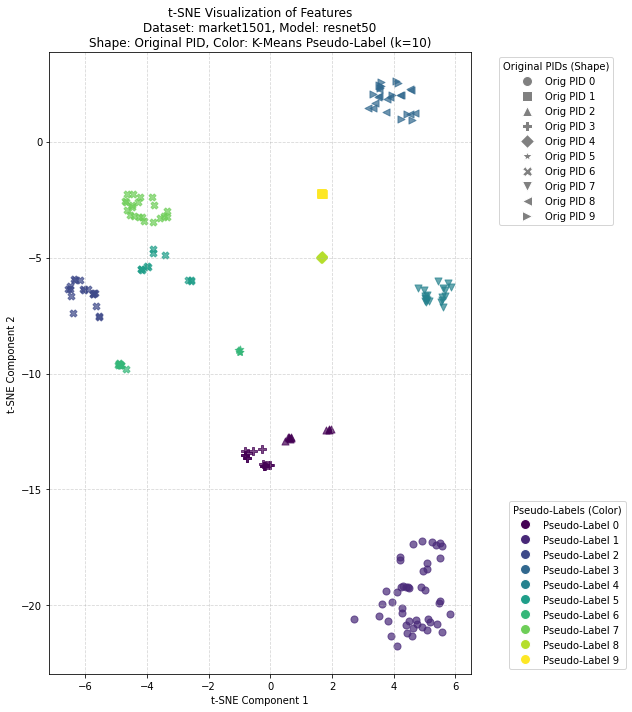

In [3]:
from __future__ import print_function, absolute_import
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(
    "ignore", category=UserWarning
)  # For sklearn kmeans n_init warning

from sklearnex import patch_sklearn

patch_sklearn()  # pip install scikit-learn-intelex

import argparse
import os.path as osp
import random
import numpy as np
import os
import sys

sys.path.append(os.getcwd())  # Ensure clepr is in path

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import collections

import torch
from torch import nn
from torch.utils.data import DataLoader

from clepr import datasets
from clepr import models

import time
from collections import OrderedDict
import numpy as np
import torch

from clepr.evaluation_metrics import cmc, mean_ap

# from clepr.feature_extraction import extract_cnn_feature
from collections import OrderedDict


from clepr.utils import to_torch


def extract_cnn_feature(model, inputs, modules=None):
    model.eval()
    # with torch.no_grad():
    inputs = to_torch(inputs)
    if modules is None:
        outputs = model(inputs)
        outputs = outputs.data.cpu()
        return outputs
    # Register forward hook for each module
    outputs = OrderedDict()
    handles = []
    for m in modules:
        outputs[id(m)] = None

        def func(m, i, o):
            outputs[id(m)] = o.data.cpu()

        handles.append(m.register_forward_hook(func))
    model(inputs)
    for h in handles:
        h.remove()
    return list(outputs.values())


from clepr.utils.meters import AverageMeter
from clepr.utils.rerank import re_ranking


# from clepr.evaluators import extract_features
def extract_features(model, data_loader, print_freq=10, metric=None):
    model.eval()
    batch_time = AverageMeter()
    data_time = AverageMeter()

    features = OrderedDict()
    labels = OrderedDict()

    end = time.time()
    with torch.no_grad():
        for i, (imgs, fnames, pids, _) in enumerate(data_loader):
            data_time.update(time.time() - end)

            outputs = extract_cnn_feature(model, imgs)
            for fname, output, pid in zip(fnames, outputs, pids):
                features[fname] = output
                labels[fname] = pid

            batch_time.update(time.time() - end)
            end = time.time()

            if (i + 1) % print_freq == 0:
                print(
                    "Extract Features: [{}/{}]\t"
                    "Time {:.3f} ({:.3f})\t"
                    "Data {:.3f} ({:.3f})\t".format(
                        i + 1,
                        len(data_loader),
                        batch_time.val,
                        batch_time.avg,
                        data_time.val,
                        data_time.avg,
                    )
                )

    return features, labels


from clepr.utils.data import transforms as T
from clepr.utils.data.preprocessor import Preprocessor
from clepr.utils.serialization import load_checkpoint

# --- Configuration ---
DATA_DIR = (
    "examples/data"  # Path to your 'data' directory (e.g., containing 'market1501')
)
MODEL_CHECKPOINT_FILEPATH = rf"logs/dukemtmcTOmarket1501/resnet50-CLEPR-700-0.3-T0.1-iters400-epochs120/model_best.pth.tar"
DATASET_NAME = "market1501"
ARCH = "resnet50"  # Model architecture used for training
FEATURES_DIM = (
    0  # Or the specific feature dimension if not 0 (e.g., 2048 for ResNet50 default)
)
NUM_CLUSTERS_KMEANS = 10  # How many clusters for K-Means (pseudo-labels)
NUM_PIDS_TO_VISUALIZE = NUM_CLUSTERS_KMEANS
HEIGHT = 256
WIDTH = 128
BATCH_SIZE = 64  # For feature extraction
WORKERS = 0  # For DataLoader, 0 for main process
SEED = 42

# Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# --- End Configuration ---


def get_data(name, data_dir):
    root = osp.join(data_dir, name)
    dataset = datasets.create(name, root)
    return dataset


def get_vis_loader(
    dataset_train_samples, height, width, batch_size, workers, dataset_images_dir
):
    normalizer = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    test_transformer = T.Compose(
        [T.Resize((height, width), interpolation=3), T.ToTensor(), normalizer]
    )
    # dataset_train_samples is a list of (img_path, pid, camid)
    vis_loader = DataLoader(
        Preprocessor(
            dataset_train_samples, root=dataset_images_dir, transform=test_transformer
        ),
        batch_size=batch_size,
        num_workers=workers,
        shuffle=False,
        pin_memory=False,
    )  # Pin memory False for CPU
    return vis_loader


def load_trained_model(arch, features_dim, num_classes, checkpoint_path):
    print(f"Loading model: {arch} from {checkpoint_path}")
    # Create a base model structure (num_classes can be arbitrary for feature extraction if no classifier used)
    # However, the MMT models use a classifier, so let's try to match args.num_clusters from training.
    # If checkpoint saves args, use that, otherwise make a good guess (e.g. 500 for Market1501)
    # For visualization, we primarily need the backbone.
    model = models.create(
        arch, num_features=features_dim, dropout=0, num_classes=num_classes
    )  # Example num_classes

    # Load checkpoint
    checkpoint = load_checkpoint(checkpoint_path)

    # Handle DataParallel wrapper if checkpoint was saved with it
    state_dict = checkpoint["state_dict"]
    if "module." in list(state_dict.keys())[0]:
        # Model was saved with nn.DataParallel
        # Create a new state_dict without the 'module.' prefix
        from collections import OrderedDict

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:]  # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)
    else:
        model.load_state_dict(state_dict)

    model.cpu()  # Move model to CPU
    model.eval()  # Set to evaluation mode
    print("Model loaded successfully and moved to CPU.")
    return model


def main_visualization():
    print("Starting visualization script...")
    print(f"Using dataset: {DATASET_NAME}, Model arch: {ARCH}")

    # 1. Load dataset
    dataset = get_data(DATASET_NAME, DATA_DIR)
    print(f"Dataset '{DATASET_NAME}' loaded. Train samples: {len(dataset.train)}")

    # 2. Select a subset of PIDs and their samples from the training set
    # dataset.train is a list of tuples: (fname, pid, camid)
    pids_in_train = sorted(list(set(item[1] for item in dataset.train)))
    if len(pids_in_train) < NUM_PIDS_TO_VISUALIZE:
        print(
            f"Warning: Dataset has only {len(pids_in_train)} PIDs. Visualizing all of them."
        )
        selected_pids = pids_in_train
    else:
        # Select the first NUM_PIDS_TO_VISUALIZE PIDs for consistency
        # Or you can pick specific PIDs: e.g., selected_pids = [pids_in_train[i] for i in [0, 10, 20, 30, 40]]
        selected_pids = pids_in_train[:NUM_PIDS_TO_VISUALIZE]

    print(f"Selected PIDs for visualization: {selected_pids}")

    samples_for_vis = []
    original_labels_for_vis = []
    for item in dataset.train:
        if item[1] in selected_pids:
            samples_for_vis.append(item)  # (fname, pid, camid)
            original_labels_for_vis.append(item[1])  # Store original PID

    if not samples_for_vis:
        print("Error: No samples found for the selected PIDs. Exiting.")
        return

    print(f"Number of samples for visualization: {len(samples_for_vis)}")

    # 3. Create DataLoader for these samples
    vis_loader = get_vis_loader(
        samples_for_vis, HEIGHT, WIDTH, BATCH_SIZE, WORKERS, dataset.images_dir
    )

    # 4. Load trained model
    # Determine num_classes for model creation. Often args.num_clusters from training script.
    # If your checkpoint contains 'args', you could load them. For simplicity, hardcoding a common value.
    # The 'best_mAP' in checkpoint could give a hint if it's an EMA model for mAP.
    # The checkpoint from your script likely saves model_1_ema or model_2_ema.
    # Let's assume your original script trained with num_clusters=500 (a common default)
    # This num_classes is for the classifier layer in the model, not for our K-Means.
    trained_num_clusters = (
        700  # Adjust if your training used a different args.num_clusters
    )

    model_checkpoint_path = MODEL_CHECKPOINT_FILEPATH
    if not osp.exists(model_checkpoint_path):
        print(f"ERROR: Model checkpoint not found at {model_checkpoint_path}")
        return

    model = load_trained_model(
        ARCH, FEATURES_DIM, trained_num_clusters, model_checkpoint_path
    )

    # 5. Extract features
    print("Extracting features for selected samples...")
    features_dict, fnames = extract_features(
        model, vis_loader, print_freq=10
    )  # _ is fnames
    extracted_features_list = []
    # A safer way to get ordered features:
    # The `fnames` returned by `extract_features` is a list of filenames in processing order.
    fnames_ordered_by_extraction = fnames
    extracted_features_list = [
        features_dict[fname].cpu().numpy() for fname in fnames_ordered_by_extraction
    ]

    # Verify lengths
    if len(extracted_features_list) != len(original_labels_for_vis):
        print(
            f"Error: Mismatch in feature count ({len(extracted_features_list)}) and label count ({len(original_labels_for_vis)})."
        )
        print(
            "This might be due to path mismatches or an issue in feature extraction order."
        )
        # Fallback: try assuming dict.values() order (Python 3.7+)
        # This is what original script does for cf_1 = torch.stack(list(dict_f.values())).numpy()
        # But let's first check if fnames_ordered_by_extraction works
        # If all fnames_ordered_by_extraction are keys in features_dict, we are good.
        missing_keys = [
            fn for fn in fnames_ordered_by_extraction if fn not in features_dict
        ]
        if missing_keys:
            print(
                f"Error: Some filenames from extraction order are not in features_dict: {missing_keys[:5]}"
            )
            print(
                "Attempting fallback based on dictionary values order (may not be reliable)."
            )
            # This is a potential issue if the order from dict.values() is not guaranteed.
            # For this visualization, if NUM_PIDS_TO_VISUALIZE is small, it might be okay.
            extracted_features_list = [
                feat.cpu().numpy() for feat in features_dict.values()
            ]
            if len(extracted_features_list) != len(original_labels_for_vis):
                print(
                    "Fallback failed. Feature and label count still mismatch. Exiting."
                )
                return
            print(
                "Fallback applied. Continuing with potentially unordered features relative to labels."
            )
        else:
            print("Features successfully ordered according to extraction.")

    features_np = np.array(extracted_features_list)
    features_np = normalize(features_np, axis=1)  # L2 normalize
    print(f"Features extracted and normalized. Shape: {features_np.shape}")

    # 6. Perform K-Means clustering for pseudo-labels
    print(f"Performing K-Means clustering with k={NUM_CLUSTERS_KMEANS}...")
    # kmeans = KMeans(n_clusters=NUM_CLUSTERS_KMEANS, random_state=SEED, n_init="auto")
    kmeans = KMeans(n_clusters=NUM_CLUSTERS_KMEANS, random_state=SEED, n_init=10)
    pseudo_labels = kmeans.fit_predict(features_np)
    print("K-Means clustering complete.")

    # 7. t-SNE dimensionality reduction
    print("Performing t-SNE reduction (this may take a moment)...")
    # Adjust perplexity if number of samples is small
    perplexity_val = min(30, features_np.shape[0] - 1)
    if perplexity_val <= 0:
        print(
            f"Error: Not enough samples ({features_np.shape[0]}) for t-SNE. Need at least 2. Exiting."
        )
        return

    tsne = TSNE(
        n_components=2,
        random_state=SEED,
        perplexity=perplexity_val,
        n_iter=1000,
        verbose=0,
    )
    features_tsne = tsne.fit_transform(features_np)
    print(f"t-SNE reduction complete. Shape: {features_tsne.shape}")

    # 8. Plotting
    print("Plotting results...")
    plt.figure(figsize=(12, 10))

    # Define markers for original PIDs and colors for pseudo-labels
    unique_original_pids = sorted(list(set(original_labels_for_vis)))
    markers = [
        "o",
        "s",
        "^",
        "P",
        "D",
        "*",
        "X",
        "v",
        "<",
        ">",
    ]  # Add more if NUM_PIDS_TO_VISUALIZE > 10
    pid_to_marker = {
        pid: markers[i % len(markers)] for i, pid in enumerate(unique_original_pids)
    }

    # Use a colormap for pseudo-labels
    cmap = plt.cm.get_cmap("viridis", NUM_CLUSTERS_KMEANS)  # Or 'tab10', 'Set3', etc.

    for i in range(features_tsne.shape[0]):
        original_pid = original_labels_for_vis[i]
        pseudo_label_cluster = pseudo_labels[i]

        plt.scatter(
            features_tsne[i, 0],
            features_tsne[i, 1],
            marker=pid_to_marker[original_pid],
            color=cmap(pseudo_label_cluster),
            s=50,
            alpha=0.7,
        )

    # Create legend for original PIDs (shapes)
    legend_elements_pids = [
        plt.Line2D(
            [0],
            [0],
            marker=pid_to_marker[pid],
            color="w",
            label=f"Orig PID {pid}",
            markerfacecolor="grey",
            markersize=10,
        )
        for pid in unique_original_pids
    ]

    # Create conceptual legend for pseudo-labels (colors)
    # This is harder to do directly unless you map specific cluster IDs to names
    # A simple way is to show a color bar or just state that color indicates pseudo-cluster
    legend_elements_pseudo = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=f"Pseudo-Label {i}",
            markerfacecolor=cmap(i),
            markersize=10,
        )
        for i in range(NUM_CLUSTERS_KMEANS)
    ]

    # Combine legends
    # Place first legend
    leg1 = plt.legend(
        handles=legend_elements_pids,
        title="Original PIDs (Shape)",
        loc="upper right",
        bbox_to_anchor=(1.35, 1),
    )
    plt.gca().add_artist(leg1)  # Add the first legend manually to enable a second one

    # Place second legend
    plt.legend(
        handles=legend_elements_pseudo,
        title="Pseudo-Labels (Color)",
        loc="lower right",
        bbox_to_anchor=(1.38, 0),
    )

    plt.title(
        f"t-SNE Visualization of Features\nDataset: {DATASET_NAME}, Model: {ARCH}\nShape: Original PID, Color: K-Means Pseudo-Label (k={NUM_CLUSTERS_KMEANS})"
    )
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make space for legends

    plot_filename = (
        f"tsne_visualization_{DATASET_NAME}_{ARCH}_k{NUM_CLUSTERS_KMEANS}.png"
    )
    plt.savefig(plot_filename, dpi=300, bbox_inches="tight")
    print(f"Plot saved to {plot_filename}")
    plt.show()


main_visualization()